# Visualization: Conformational Selection Results
***
**Visualize the results** computed in the [previous notebook](5_Conformational_selection_using_k_confs.ipynb).

<div class="alert alert-info">
The plots generated inside this notebook appear in the main manuscript and/or in the Supporting Information file.
</div>


The conformational selection criteria are the following:

1. <font color='#73C1FF'>&#11044;</font> Random Selection.

2. <font color='#203647'>&#11044;</font> Recursive Feature Elimination Ranking, computed in the [previous notebook](./4_Recursive_Feature_Elimination.ipynb)
3. <font color='#DE4444'>&#11044;</font> Best to worst AUC-ROC conformations (single-conformation docking)
4. <font color='#6DAA5C'>&#11044;</font>Worst to best AUC-ROC conformations (single-conformation docking)
5. <font color='#FFA723'>&#11044;</font> Conformations with bigger ligands to smaller (or no ligands)
6. <font color='#A65FFF'>&#11044;</font> Conformations from largest to smallest pocket volume

In [1]:
import pandas as pd
import joblib 
# Load some auxiliary functions
%run ../../helper_modules/Helper_functions_for_nRepeats_x_kCV.ipynb

### Load the results file

In [2]:
# Load the results file
path_to_file = './conformational_selection_30x4cv_using_k_confs.obj'

with open(path_to_file, 'rb') as f:
    conf_sel_results = joblib.load(f)

In [3]:
# Determine the k values used
k_values = [int(i.split('_')[1]) 
            for i in conf_sel_results['random'].keys()]
k_values

[1, 2, 4, 8, 16, 32, 64]

In [4]:
# Map new names for each VS method, for plotting
sbvs_names = {
     'ml_lr': 'LR',
     'ml_xgb': 'GBT',
     'ml_dclf': 'DClf',
     'cs_MEAN': 'csAVG',
     'cs_GEOM': 'csGEO',
     'cs_MIN': 'csMIN'
}
sbvs_methods = list(sbvs_names.values())

## Plot results

In [5]:
%load_ext rpy2.ipython

### AUC-ROC

In [6]:
metric_name = 'roc_auc'
dict_res = {test_name: 
            get_group_stats(
               df, 
               metric_name = metric_name, 
               indexes_values = k_values)\
            .replace(sbvs_names)
            for test_name, df in conf_sel_results.items()
           }

df_roc = pd.concat(dict_res.values(), 
                   keys = dict_res.keys())\
                   .reset_index()\
                   .drop(['level_1'], axis=1)\
                   .rename(columns={'level_0': 'selection'})

# Just if needed
df_roc.method = df_roc.method.replace({'cs_GEO': 'csGEO'})

#### Initialize some variables

In [7]:
%%time
# **********************************
# Extract the individual predictions
# **********************************

# Single conformation performance SCP reference values
RANDOM_STATE = 1
protein_name = 'egfr'
R_a = 0.04
# Use the same `random_state` value to parse to `RepeatedStratifiedKFold`
filename = f'./cachedir/SCP_values_randState_{RANDOM_STATE}_{protein_name}'
# Created in the 2_30x4CV_analysis.ipynb notebook
scp_values = joblib.load(filename)

# Report the values
for m, values in scp_values.items():
    print(f'SCP values of {m} => ' + 
          f'mean: {values[0]:.2f} +/- {values[1]:.2f}, ' + 
          f'max: {values[2]:.2f}')
    
# Keep only the max SCP AUC-ROC and max SCP NEF
maxSCP_auc_roc = scp_values['roc_auc'][2]
maxSCP_nef     = scp_values['nef_Ra'][2]

SCP values of roc_auc => mean: 0.68 +/- 0.08, max: 0.85
SCP values of nef_Ra => mean: 0.15 +/- 0.05, max: 0.32
CPU times: user 1.84 ms, sys: 2.43 ms, total: 4.28 ms
Wall time: 19.6 ms


In [8]:
%%R -i k_values -i sbvs_methods -i protein_name -i R_a -i maxSCP_auc_roc -i maxSCP_nef
source('../../R_scripts/plot_violinBox.R')

# Initialize some variables
protein_name <- protein_name
R_a <- R_a
maxSCP_auc_roc <- maxSCP_auc_roc
maxSCP_nef <- maxSCP_nef

x_ticks <- unlist(k_values)
sbvs_methods <- unlist(sbvs_methods)
select_criteria <- c('RFExgb', 'singConfAUC', 
                     'singConfAUC-Worst', 
                     'random', 'bigLigMW')
cbbPalette <- hue_pal()(10)

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Co

#### Plot using `ggplot2`

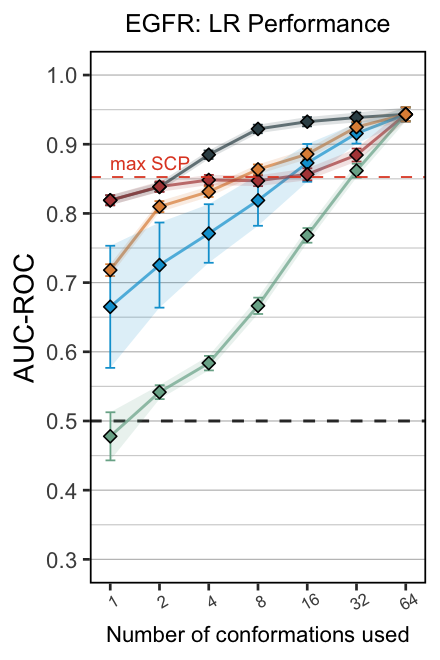

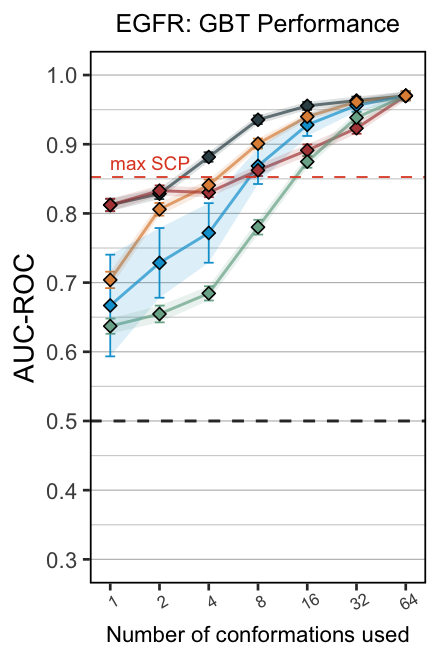

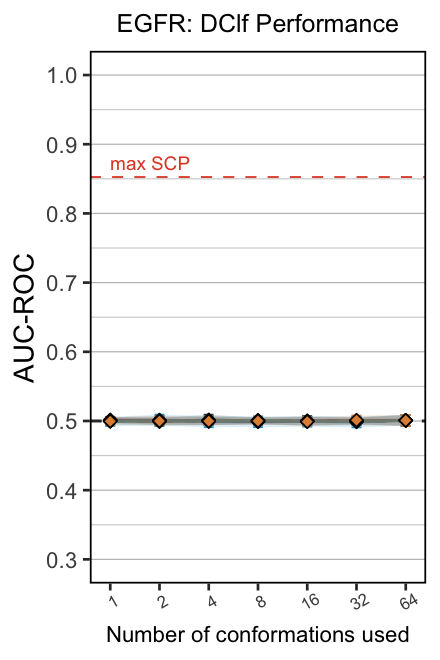

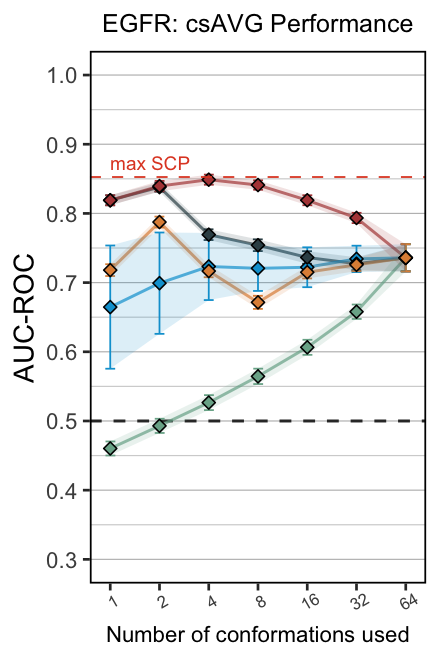

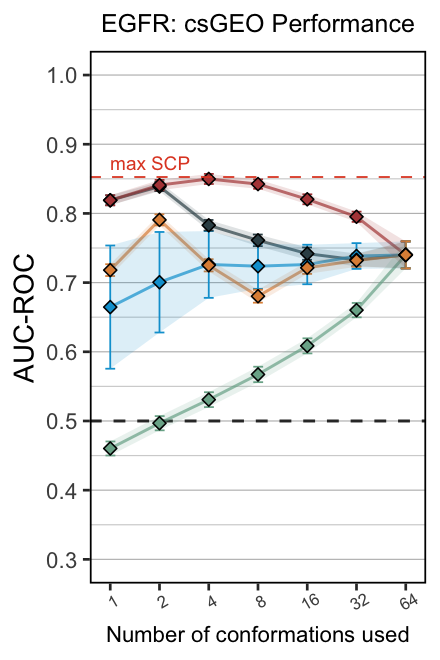

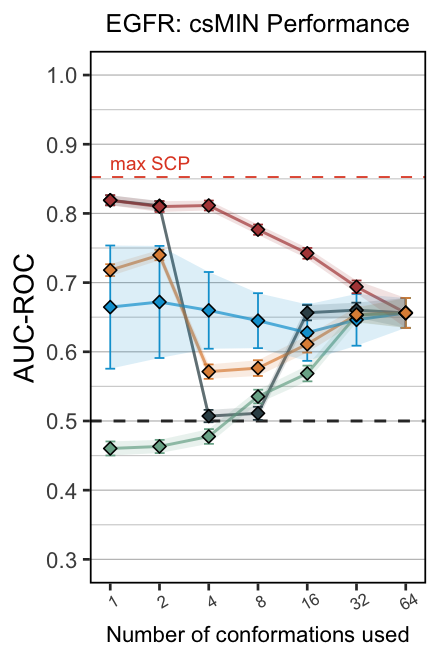

In [9]:
%%R -i df_roc -i metric_name -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')
metric_name <- 'AUC-ROC' 

for(vs_method in sbvs_methods){
    df <- df_roc %>%
    filter(method == vs_method) %>%
    filter(index %in% x_ticks) %>%
    filter(selection %in% select_criteria)

    p = plot_lines(df, cbbPalette=cbbPalette, 
                   y_min = 0.3, 
                   y_max = 1.0, 
                   error_dodge = 0.01, error_size = 0.3, error_width=1,
                   point_size = 1.5, line_size  = 0.5, shape=23,
                   add_ribbon = T, ribbon_alpha = 0.15, 
                   include_color_scale = F,
                   base_h_line = 0.5, switch_x = FALSE,  
                   ticks.text.angle = 30, ticks.text.size = 6,  
                   title.size = 9,
#                    legend.position = 'right',
                   y_label = metric_name,
                   x_label="Number of conformations used") +
                   scale_x_continuous(breaks = x_ticks,  trans = 'log2') +
                   scale_color_jama() + scale_fill_jama() +
                   ggtitle(paste0(toupper(protein_name), ': ', vs_method, ' Performance')) +
    add_ref_values('max SCP', maxSCP_auc_roc, x=1.0,
               color='#E1492B', size=2.4, y_add=0.02)
    
    # Save the picture
    metric <- 'ACU-ROC'
    methodology <- 'RFE_plots/'
    save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
    filename <- paste0(save_path, methodology,
                       paste(protein_name, vs_method, metric, 'RFE.pdf', sep='_'))
    ggsave(filename, plot=p, width=2.2, height= 3.3) 
    print(p)
    
}

### Normalized Enrichment Factor

In [10]:
metric_name = 'nef_05_Ra'
dict_res = {test_name: 
            get_group_stats(
               df, 
               metric_name = metric_name, 
               indexes_values = k_values)\
            .replace(sbvs_names)
            for test_name, df in conf_sel_results.items()
           }

df_nef = pd.concat(dict_res.values(), 
                   keys = dict_res.keys())\
                   .reset_index()\
                   .drop(['level_1'], axis=1)\
                   .rename(columns={'level_0': 'selection'})
# Just if needed
df_nef.method = df_nef.method.replace({'cs_GEO': 'csGEO'})

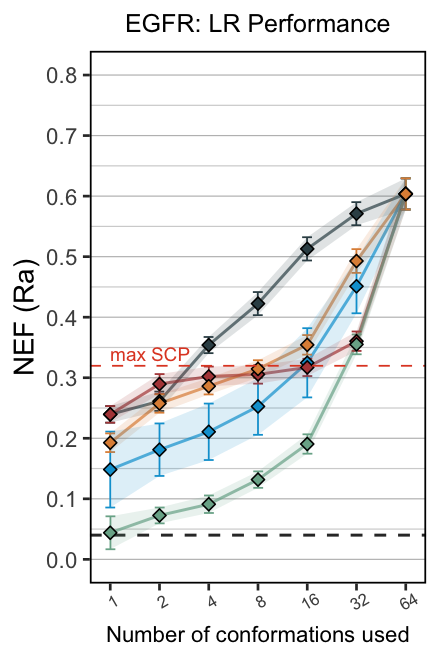

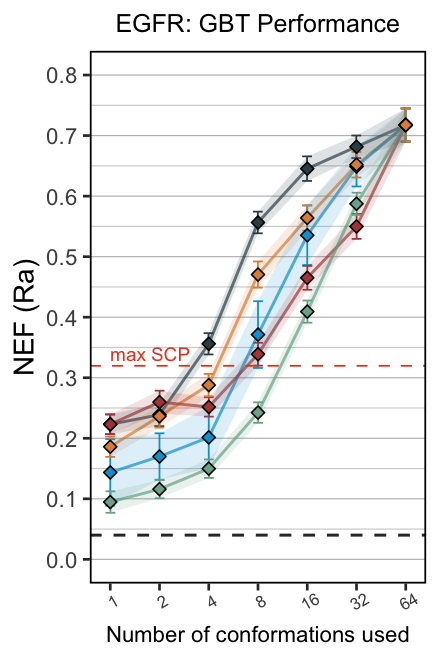

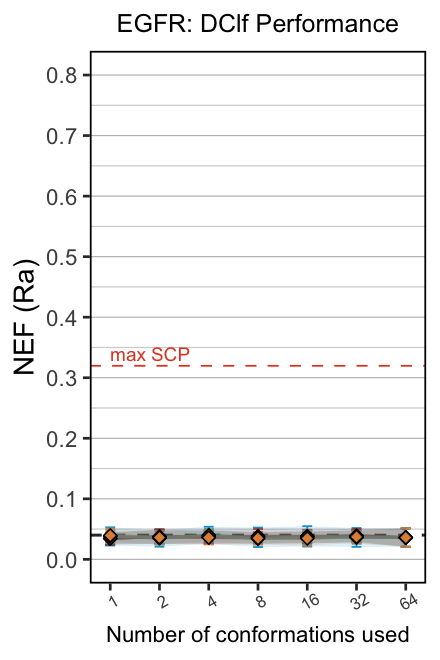

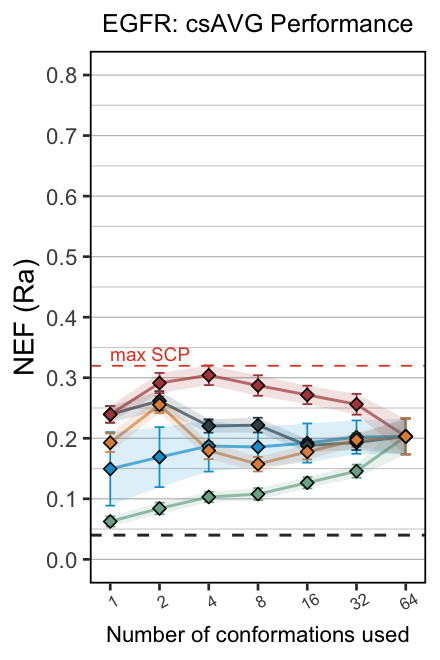

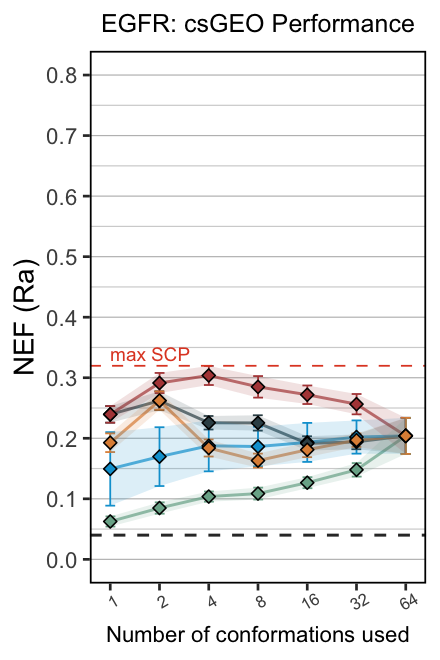

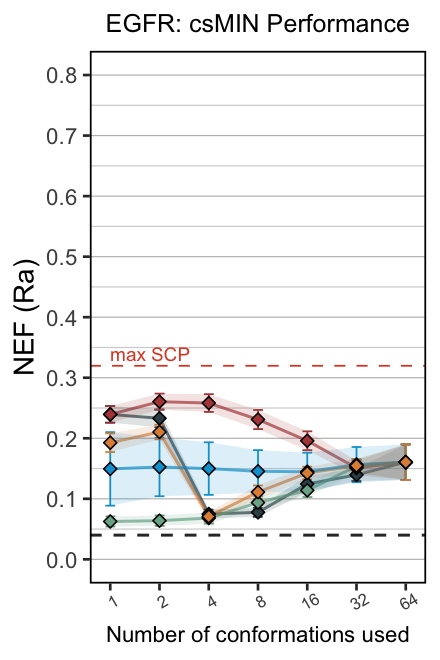

In [11]:
%%R -i df_nef -i metric_name -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')
metric_name <- 'NEF (Ra)'

for(vs_method in sbvs_methods){
    df <- df_nef %>%
    filter(method == vs_method) %>%
    filter(index %in% x_ticks) %>%
    filter(selection %in% select_criteria)

    p = plot_lines(df, cbbPalette=cbbPalette, 
                   y_min = 0.0, 
                   y_max = 0.8, 
                   error_dodge = 0.01, error_size = 0.3, error_width=1,
                   point_size = 1.5, line_size  = 0.5, shape=23,
                   add_ribbon = T, ribbon_alpha = 0.15, 
                   include_color_scale = F,
                   base_h_line = R_a, switch_x = FALSE,  
                   ticks.text.angle = 30, ticks.text.size = 6,  
                   title.size = 9,
#                    legend.position = 'right',
                   y_label = metric_name,
                   x_label="Number of conformations used") +
                   scale_x_continuous(breaks = x_ticks,  trans = 'log2') +
                   scale_color_jama() + scale_fill_jama() +
                   ggtitle(paste0(toupper(protein_name), ': ', vs_method, ' Performance')) +
        add_ref_values('max SCP', maxSCP_nef, x=1.,
               color='#E1492B', size=2.4, y_add=0.02)
    
    # Save the picture
    metric <- 'NEF'
    methodology <- 'RFE_plots/'
    save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
    filename <- paste0(save_path, methodology,
                       paste(protein_name, vs_method, metric, 'RFE.pdf', sep='_'))
    ggsave(filename, plot=p, width=2.2, height= 3.3) 
    print(p)
}

## Plot for the supplementary figure showing the performance of the ML models with the worst 32 conformantions

In [12]:
metric_name = 'roc_auc'
dict_res = {test_name: 
            get_group_stats(
               df, 
               metric_name = metric_name, 
               indexes_values = k_values)\
            .replace(sbvs_names)
            for test_name, df in conf_sel_results.items()
           }

df_roc_worst = pd.concat(dict_res.values(), 
                   keys = dict_res.keys())\
                   .reset_index()\
                   .drop(['level_1'], axis=1)\
                   .rename(columns={'level_0': 'selection'})
# Just if needed
df_roc_worst = df_roc_worst[
      (df_roc_worst.selection == 'singConfAUC-Worst') &
      (df_roc_worst.method.isin(['LR', 'GBT'])) & 
        (df_roc['index'] <= 32)]
# Get the avg SCP value
avgSCP_auc_roc = scp_values['roc_auc'][0]

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



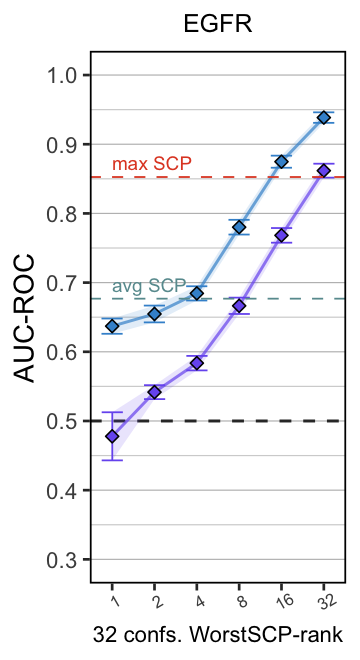

In [14]:
%%R -i df_roc_worst -i metric_name -i avgSCP_auc_roc -w 1.8 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')
metric_name <- 'AUC-ROC' 
df <- df_roc_worst %>% 
    rename(selection = method, method = selection)
cbbPalette=c('#3F93D2', '#785EF0')
p = plot_lines(df, 
               cbbPalette=cbbPalette, 
               y_min = 0.3, 
               y_max = 1, 
               error_dodge = 0.01, error_size = 0.3, error_width=1,
               point_size = 1.5, line_size  = 0.5, shape=23,
               add_ribbon = T, ribbon_alpha = 0.15, 
               include_color_scale = FALSE,
               base_h_line = 0.5, switch_x = FALSE,  
               ticks.text.angle = 30, ticks.text.size = 6,  
               title.size = 9,
               y_label = metric_name,
               x_label="32 confs. WorstSCP-rank") +
               scale_x_continuous(breaks = x_ticks,  trans = 'log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0(toupper(protein_name))) +
add_ref_values('max SCP', maxSCP_auc_roc, x=1.0,
           color='#E1492B', size=2.4, y_add=0.02) +
add_ref_values('avg SCP', avgSCP_auc_roc, x=1.0,
           color='#689A9E', size=2.4, y_add=0.02) +
scale_fill_manual(values=cbbPalette, name = 'selection') +
scale_color_manual(values=cbbPalette, name = 'selection')

# Save the picture
metric <- 'AUC-ROC'
methodology <- 'RFE_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(protein_name, vs_method, metric, 'worst32RANK.pdf', sep='_'))
ggsave(filename, plot=p, width=1.8, height= 3.3) 
print(p)